# Tracking

- [TensorBoard](https://www.tensorflow.org/tensorboard)
- [MLflow](https://mlflow.org/)
- [Weights & Biases](https://wandb.ai/)
- ...

`$ tensorboard --logdir=<path to folder>`

In [ ]:
#!pip install -q tensorboard torchmetrics

In [ ]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms.v2 as T

from torchmetrics.classification import Accuracy

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.ToPureTensor(),
])

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

In [ ]:
training_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
idx2class = {i: c for c, i in training_data.class_to_idx.items()}
idx2class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
sample = training_data[0]
len(sample)

2

In [ ]:
sample[0].shape, sample[1]

(torch.Size([1, 28, 28]), 9)

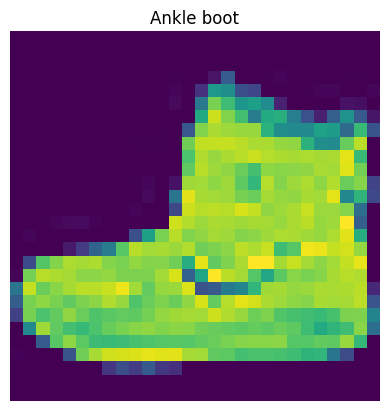

In [ ]:
plt.imshow(sample[0].permute(1, 2, 0))
plt.title(idx2class[sample[1]])
plt.axis(False)
plt.show()

In [ ]:
len(training_data), len(test_data)

(60000, 10000)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=64)

In [ ]:
len(train_dataloader), len(test_dataloader)

(937, 157)

In [ ]:
60000/64, 10000/64

(937.5, 156.25)

In [ ]:
i = 0
for batch in train_dataloader:
    if i == 936:
        print(batch[0].shape, batch[1].shape)
    i += 1

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [ ]:
i = 0
for batch in test_dataloader:
    if i == 156:
        print(batch[0].shape, batch[1].shape)
    i += 1

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),

            nn.Flatten(),

            nn.LazyLinear(10),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
num_epoch = 5
learning_rate = 1e-3
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

loss_fn = nn.CrossEntropyLoss()
metric_fn = Accuracy(task="multiclass", num_classes=10).to(device)
model = ImageClassifier().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
global_step = -1
for epoch in range(num_epoch):
    # Train
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        accuracy = metric_fn(y_pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        global_step += 1

        if batch_idx % 100 == 0:
            train_loss = loss.item()
            train_accuracy = accuracy.item()
            writer.add_scalar("loss", train_loss, global_step=global_step)
            writer.add_scalar("accuracy", train_accuracy, global_step=global_step)
            print(f"loss: {loss:.4f} accuracy: {accuracy:.4f} [{batch_idx} / {len(train_dataloader)}]")
    
    # Evaluate
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            eval_loss += loss_fn(y_pred, y).item()
            eval_accuracy += metric_fn(y_pred, y).item()

    eval_loss /= len(test_dataloader)
    eval_accuracy /= len(test_dataloader)
    writer.add_scalar("eval_loss", eval_loss, global_step=epoch)
    writer.add_scalar("eval_accuracy", eval_accuracy, global_step=epoch)

    print(f"Eval metrics: \nAccuracy: {eval_accuracy:.4f}, Avg loss: {eval_loss:.4f} \n")

loss: 2.4895 accuracy: 0.0469 [0 / 937]
loss: 1.3341 accuracy: 0.6719 [100 / 937]
loss: 0.7815 accuracy: 0.8438 [200 / 937]
loss: 0.9272 accuracy: 0.6875 [300 / 937]
loss: 0.7172 accuracy: 0.7500 [400 / 937]
loss: 0.6734 accuracy: 0.7812 [500 / 937]
loss: 0.6763 accuracy: 0.7500 [600 / 937]
loss: 0.6554 accuracy: 0.7812 [700 / 937]
loss: 0.6521 accuracy: 0.7500 [800 / 937]
loss: 0.4981 accuracy: 0.8281 [900 / 937]
Eval metrics: 
Accuracy: 0.8111, Avg loss: 0.5568 

loss: 0.4697 accuracy: 0.8594 [0 / 937]
loss: 0.5868 accuracy: 0.7812 [100 / 937]
loss: 0.3112 accuracy: 0.9062 [200 / 937]
loss: 0.6228 accuracy: 0.7812 [300 / 937]
loss: 0.5299 accuracy: 0.7812 [400 / 937]
loss: 0.4812 accuracy: 0.7969 [500 / 937]
loss: 0.4970 accuracy: 0.8281 [600 / 937]
loss: 0.5817 accuracy: 0.7969 [700 / 937]
loss: 0.5603 accuracy: 0.8125 [800 / 937]
loss: 0.3904 accuracy: 0.8594 [900 / 937]
Eval metrics: 
Accuracy: 0.8382, Avg loss: 0.4635 

loss: 0.3591 accuracy: 0.8750 [0 / 937]
loss: 0.4801 accurac